https://aviris.jpl.nasa.gov/dataportal/

In [1]:
import requests
import tarfile
import re
import torch
from torchvision import transforms
import numpy as np

In [6]:
def is_header(filename):
    return filename.endswith('_img.hdr')
def is_data(filename):
    return filename.endswith('_img')
def get_size(header):
    nsamp_match = re.search(r"samples\s*=\s*(\d+)", header)
    nlines_match = re.search(r"lines\s*=\s*(\d+)", header)
    nbands_match = re.search(r"bands\s*=\s*(\d+)", header)
    nsamp = int(nsamp_match.group(1))
    nlines = int(nlines_match.group(1))
    nbands = int(nbands_match.group(1))
    return nsamp, nlines, nbands
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t

In [3]:
url_list = [
    'https://popo.jpl.nasa.gov/avcl/y10_data/f100829t01p00r05.tar.gz'
]

In [4]:
%%time
for url in url_list:
    response = requests.get(url)
    try:
        with open('tmp.tar.gz', 'wb') as f:
            f.write(response.content)
        with tarfile.open('tmp.tar.gz', 'r:gz') as tar:
            names = tar.getnames()
            header = next(filter(is_header, names), None)   
            header = tar.extractfile(header)
            header = header.read().decode('utf-8')
            nsamp, nlines, nbands = get_size(header)
            shape = (nlines, nsamp, nbands)
            dtype = np.int16
            data = next(filter(is_data, names), None)
            x = tar.extractfile(data).read()
            x = np.frombuffer(x, dtype=dtype)
            x = x.reshape(shape)
            x = torch.from_numpy(x)   
    except:
        pass

CPU times: user 17.2 s, sys: 3.99 s, total: 21.2 s
Wall time: 50.1 s


<timed exec>:18: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


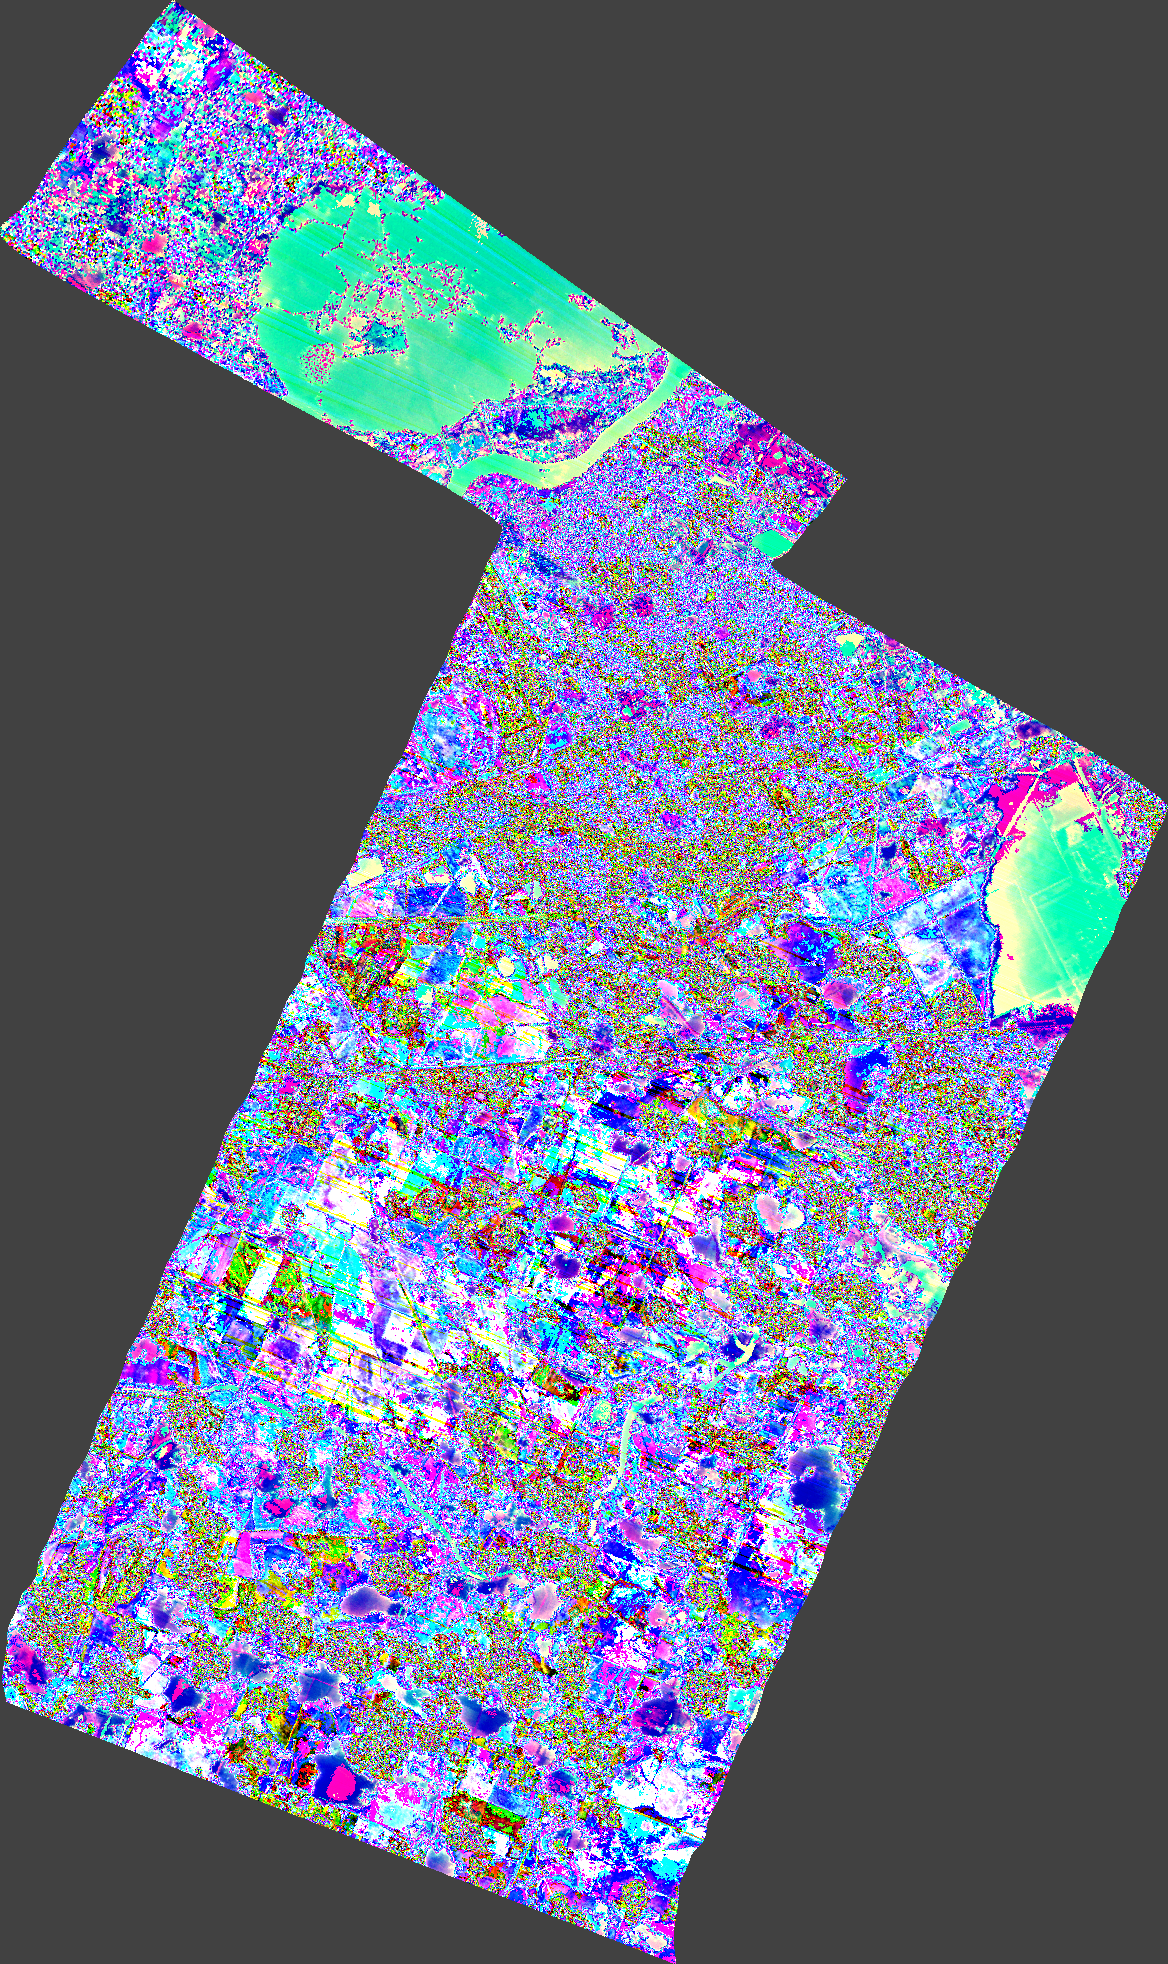

In [12]:
z = x[:,:,[20,100,180]]
z = z.to(torch.float)
z = z - z.mean()
z = 3 * z / z.std()
z = torch.clamp(z,min=-3,max=3)
z = z / 6
z = z.permute(2,0,1)
transforms.ToPILImage()(pt_to_pil(z))